Author: Pavan Kumar Bondalapati<br>
Email: pb7ak@virginia.edu<br>
Class: DS 5001<br>
Date: May 11, 2021<br>

In [1]:
# Code is adapted from Raf Alvarado
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [2]:
OHCO = ['book_num', 'fable_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
FABLES = OHCO[:2]
BOOKS = OHCO[:1]
n_terms = 4000

In [3]:
LIB = pd.read_csv('data_out/LIB.csv', index_col=['book_num'])
TOKEN = pd.read_csv('data_out/TOKEN.csv', index_col=OHCO)
VOCAB = pd.read_csv('data_out/VOCAB.csv', index_col=['term_str'], na_filter=False)

In [4]:
def get_tfidf(bag, tf_method='sum', item_type='term_str'):
    
    global TOKEN, VOCAB
    
    # Create bag of items (terms or stems)
    BOW = TOKEN.groupby(bag+[item_type])[item_type].count()\
        .to_frame().rename(columns={item_type:'n'})

    # Add binary count column
    BOW['c'] = BOW.n.astype('bool').astype('int')

    # Compute TF
    D = BOW.groupby(bag).n
    if tf_method == 'sum':
        BOW['tf'] = D.apply(lambda x: x / x.sum())
    elif tf_method == 'max':
        BOW['tf'] = D.apply(lambda x: .4 + .6 * (x / x.max())) # See Manning, et al. for choice of α
    elif tf_method == 'bool':
        BOW['tf'] = D.apply(lambda x: x.astype('bool') / x.astype('bool').sum())
    elif tf_method == 'raw':
        BOW['tf'] = BOW['n']
    elif tf_method == 'bool_raw':
        BOW['tf'] = BOW['c']
        
    # Compute DF
    VOCAB['df'] = BOW.groupby('term_str').n.count()
    N_docs = len(D.groups)
    VOCAB['idf'] = np.log2(N_docs/VOCAB.df)
    VOCAB['dfidf'] = VOCAB.df * VOCAB.idf
    
    # Compute TFIDF (local term significance)
    BOW['tfidf'] = BOW.apply(lambda x: x.tf * VOCAB.loc[x.name[len(bag)]].idf, 1) #BOW.tf * VOCAB.idf
    
    # Compute aggregate TFIDF (global term significance)
    VOCAB['tfidf_sum'] = BOW.groupby('term_str').tfidf.sum()
        
    return BOW

In [5]:
VOCAB

,term_id,n,num,stop,stem_porter,stem_snowball,stem_lancaster,pos_max
term_str,,,,,,,,
,0,31063,0,0,,,,","
1,1,2,1,0,1,1,1,CD
1000,2,1,1,0,1000,1000,1000,CD
109,3,1,1,0,109,109,109,CD
11,4,3,1,0,11,11,11,CD
...,...,...,...,...,...,...,...,...
ὤπς,14907,1,0,0,ὤπς,ὤπς,ὤπς,NNP
ὦ,14908,1,0,0,ὦ,ὦ,ὦ,NNP
ὦτα,14909,1,0,0,ὦτα,ὦτα,ὦτα,NNP


In [6]:
TOKEN

pos_tuple  pos  \
book_num fable_num para_num sent_num token_num                            
1        1         0        0        0              ('God', 'NNP')  NNP   
                                     1          ('reduces', 'VBZ')  VBZ   
                                     2            ('Chaos', 'NNP')  NNP   
                                     3              ('into', 'IN')   IN   
                                     4             ('order', 'NN')   NN   
...                                                            ...  ...   
15       5         21       9        19               ('at', 'IN')   IN   
                                     20             ('what', 'WP')   WP   
                                     21             ('time', 'NN')   NN   
                   22       0        0               ('THE', 'DT')   DT   
                                     1               ('END', 'NN')   NN   

                                               token_str term_str  
book_num fable_num para_num sent_num token_num                     
1        1         0        0        0               God      god  
                                     1           reduces  reduces  
                                     2             Chaos    chaos  
                                     3              into     into  
                                     4             order    order  
...                                                  ...      ...  
15       5         21       9        19               at       at  
                                     20             what     what  
                                     21             time     time  
                   22       0        0               THE      the  
                                     1               END      end  

[276849 rows x 4 columns]

In [7]:
# Run for fables as bags
BOW = get_tfidf(FABLES, tf_method='max')

In [8]:
# Collapse TFIDF by books
TFIDF = BOW.tfidf.unstack(fill_value=0)
TFIDF_book = TFIDF.groupby(BOOKS).sum()
TFIDF_book

term_str,1,1000,109,11,114,1140,1186,11th,12,120,...,ὕαλος,ὕειν,ὕετος,ὕλη,ὠλέναι,ὤπς,ὦ,ὦτα,ὦτον,ῥαίνω
book_num,,,,,,,,,,,,,,,,,,,,,
1,2.392308,2.820853,0.000000,2.164595,0.000000,0.000000,0.000000,2.804962,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,2.223384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.785063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.822869,...,2.797129,2.788026,0.000000,2.797129,2.788026,0.000000,0.000000,0.000000,0.000000,2.797129
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.790799,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.798589,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,2.801654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,2.151828,0.000000,0.000000,0.000000,0.000000,2.788418,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
# Reduce features
VOCAB_SHORT = VOCAB.sort_values('tfidf_sum', ascending=False).head(n_terms).index.tolist()
TFIDF_book_short = TFIDF_book[VOCAB_SHORT]

In [10]:
TFIDF_book_short

term_str,juno,apollo,island,wings,our,tears,youth,mountain,waves,shape,...,warn,faunus,loins,python,hates,cherished,x,grain,christian,causing
book_num,,,,,,,,,,,,,,,,,,,,,
1,3.947084,2.934447,0.614309,1.711343,3.494919,2.257620,1.245334,5.598169,3.667428,4.641965,...,0.000000,0.000000,0.000000,4.060387,0.000000,2.028135,3.994652,2.028135,0.000000,1.987127
2,0.669907,2.901600,1.236672,2.285869,1.161563,2.922316,1.228544,2.239724,1.804202,4.117581,...,2.035153,0.000000,2.051144,0.000000,2.066870,0.000000,2.051144,0.000000,2.009240,0.000000
3,3.258874,0.574503,1.222803,0.561941,1.747597,1.689684,1.904022,1.667557,1.206005,1.166379,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.001116,0.000000
4,1.927380,1.731789,2.445235,3.456897,1.737003,2.834959,2.505008,2.775422,3.012727,2.905495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.249499,0.572208,3.698392,2.260361,2.378626,0.559008,1.857421,2.221612,2.398549,1.145698,...,0.000000,0.000000,1.992371,0.000000,0.000000,0.000000,0.000000,1.990672,0.000000,0.000000
6,2.542309,2.388717,1.229233,1.748166,1.721027,2.293264,1.234624,1.111915,0.596723,0.000000,...,0.000000,2.006661,0.000000,1.988635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2.500706,1.149748,3.749558,2.256491,2.303627,2.805327,1.854966,1.106242,1.193946,1.156457,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.031923,0.000000,0.000000,0.000000,2.046782
8,0.636397,1.716793,2.537269,2.918355,1.718137,0.562412,1.223324,1.100060,1.215197,2.304526,...,0.000000,0.000000,1.994553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,3.808375,1.145924,1.227693,1.117827,0.580225,2.290460,2.478057,1.655208,1.802401,1.140928,...,1.995540,1.985130,0.000000,0.000000,1.991687,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# Most significant terms by book
LIB['tfidf_sum'] = TFIDF_book_short.sum(1).sort_index()
LIB['tfidf_mean'] = TFIDF_book_short.mean(1).sort_index()

<AxesSubplot:ylabel='book_num'>

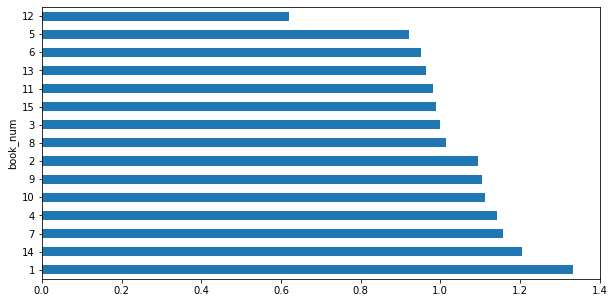

In [12]:
LIB.sort_values('tfidf_sum', ascending=False).reset_index().reset_index()\
    .set_index('book_num').tfidf_mean.plot.barh(figsize=(10, 5))

In [13]:
LIB

,book_title,book_id,book_file,author,title,tfidf_sum,tfidf_mean
book_num,,,,,,,
1,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,5334.672510,1.333668
2,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,4375.401594,1.093850
3,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,3999.756068,0.999939
4,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,4570.768601,1.142692
5,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,3689.174347,0.922294
6,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,3807.414794,0.951854
7,"The Metamorphoses of Ovid, by Publius Ovidius ...",21765,./data_in/21765-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,4632.609003,1.158152
8,"The Metamorphoses of Ovid, by Publius Ovidius ...",26073,./data_in/26073-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,4061.206981,1.015302
9,"The Metamorphoses of Ovid, by Publius Ovidius ...",26073,./data_in/26073-0.txt,Publius Ovidius Naso,The Metamorphoses of Ovid,4414.289376,1.103572


In [14]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [15]:
# Create normalized tables
df = TFIDF_book_short
L0 = df.astype('bool').astype('int') # Boolean
L1 = df.apply(lambda x: x / x.sum(), 1)
L2 = df.apply(lambda x: x / norm(x), 1)

In [16]:
# Compute distances
PAIRS['cityblock'] = pdist(df, 'cityblock')
PAIRS['euclidean'] = pdist(df, 'euclidean')
PAIRS['cosine'] = pdist(df, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')                               
PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [17]:
PAIRS.sort_values('cosine', ascending=False).style.background_gradient(cmap='GnBu', high=.5)

,,cityblock,euclidean,cosine,jaccard,dice,js,euclidean2
doc_a,doc_b,,,,,,,
1,12,5140.598861,116.736647,0.628343,0.604699,0.433383,0.601024,1.121020
2,12,4334.239478,98.072771,0.612232,0.610934,0.439816,0.600316,1.106555
5,12,3724.826822,87.387650,0.604724,0.596361,0.424868,0.595393,1.099749
3,12,3927.243291,91.233921,0.600015,0.596070,0.424572,0.592940,1.095459
4,12,4339.952863,98.482158,0.591399,0.592291,0.420749,0.587675,1.087566
10,12,4231.298850,97.093722,0.587881,0.587478,0.415907,0.585593,1.084326
7,12,4347.251925,98.682045,0.581012,0.584425,0.412853,0.583067,1.077972
6,12,3683.984084,85.754343,0.576855,0.588300,0.416731,0.584905,1.074109
12,15,3758.620428,87.056010,0.575079,0.586232,0.414659,0.583267,1.072454


In [18]:
# Create Dendrograms
LABELS = LIB.index.values.tolist()

In [19]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(5, 5)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LABELS
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

### Cosine

<Figure size 432x288 with 0 Axes>

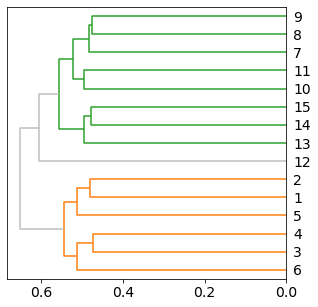

In [20]:
hca(PAIRS.cosine, color_thresh=0.6)

### JS

<Figure size 432x288 with 0 Axes>

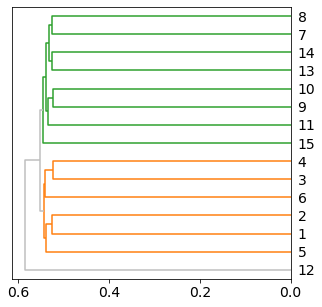

In [21]:
hca(PAIRS.js, linkage_method='weighted', color_thresh=0.545)

### Jaccard

<Figure size 432x288 with 0 Axes>

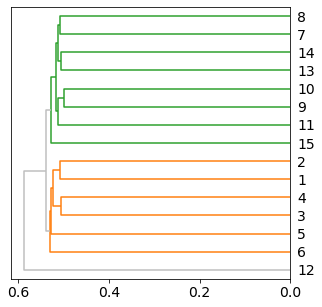

In [22]:
hca(PAIRS.jaccard, linkage_method='weighted', color_thresh=0.535)

### Dice

<Figure size 432x288 with 0 Axes>

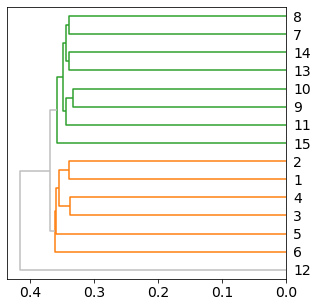

In [23]:
hca(PAIRS.dice, linkage_method='weighted', color_thresh=0.365)

### Euclidean

<Figure size 432x288 with 0 Axes>

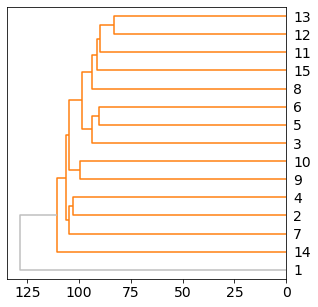

In [24]:
hca(PAIRS.euclidean, color_thresh=125)

### Cityblock

<Figure size 432x288 with 0 Axes>

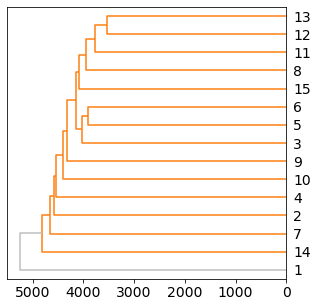

In [25]:
hca(PAIRS.cityblock, linkage_method='weighted', color_thresh=5000)